# Detecton of sugarbeet plants with YOLO11n and Cross Validation

## I Daten Vorbereiten

### Ziel
Dieser Codeabschnitt erstellt die Datenaufteilung für ein k-fold Cross-Validation-Szenario. Die Bild- und Labeldateien werden zufällig in Trainings- und Validierungssplits unterteilt und in einer klar definierten Verzeichnisstruktur organisiert.

### Beschreibung

#### 1. Initialisierung
- **Bildverzeichnis**: `datensatz_sugarbeet/img`, enthält die Bilddateien.
- **Labelverzeichnis**: `datensatz_sugarbeet/convertedSugarbeetDataset`, enthält die zugehörigen Labeldateien.
- **Ausgabeverzeichnis**: `datensatz_sugarbeet_Yolo/kfold_split`, Zielverzeichnis für die Splits.
- **Anzahl der Folds**: 5.

#### 2. Funktion `create_kfold_splits`
Die Funktion übernimmt die Erstellung der k-fold Cross-Validation-Splits:
1. **Zufällige Aufteilung**:
   - Alle Bilddateien im Bildverzeichnis werden zufällig sortiert.
   - Die Gesamtanzahl der Bilder wird gleichmäßig auf die Folds aufgeteilt.
2. **Verzeichnisstruktur**:
   - Für jeden Fold wird eine Ordnerstruktur erstellt, die Trainings- und Validierungsdaten getrennt speichert.
3. **Datenverschiebung**:
   - Bilder und zugehörige Labels werden in die entsprechenden Unterordner kopiert:
     - **Trainingsdaten**: In `train/images` und `train/labels`.
     - **Validierungsdaten**: In `val/images` und `val/labels`.

#### 3. Ergebnisse
Nach Abschluss des Prozesses enthält das Zielverzeichnis die k-fold Aufteilung der Daten, die für das Training und die Validierung verwendet werden können.


In [4]:
import os
import shutil
import random


# Define directories
image_dir = "datensatz_sugarbeet/img"
label_dir = "datensatz_sugarbeet/annotations"
output_dir = "datensatz_sugarbeet/cross_validation"

k_folds = 5

def create_kfold_splits(image_dir, label_dir, output_dir, k_folds):
    """
    Erstellt k-Fold Cross-Validation Splits.
    
    Parameters:
        image_dir: str  - Pfad zu den Bilddateien
        label_dir: str  - Pfad zu den Labeldateien
        output_dir: str - Pfad zum Ausgabeverzeichnis
        k_folds: int    - Anzahl der Folds
    """
    images = [f for f in os.listdir(image_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
    random.shuffle(images)  # Zufällige Reihenfolge
    num_images = len(images)
    fold_size = num_images // k_folds

    for fold in range(k_folds):
        # Erstelle Ordnerstruktur für jeden Fold
        fold_dir = os.path.join(output_dir, f"fold_{fold}")
        os.makedirs(f"{fold_dir}/train/images", exist_ok=True)
        os.makedirs(f"{fold_dir}/train/labels", exist_ok=True)
        os.makedirs(f"{fold_dir}/val/images", exist_ok=True)
        os.makedirs(f"{fold_dir}/val/labels", exist_ok=True)

        val_images = images[fold * fold_size : (fold + 1) * fold_size]
        train_images = [img for img in images if img not in val_images]

        # Verschiebe Trainings- und Validierungsdaten in die entsprechenden Ordner
        for img_set, img_dir, label_dir_target in [
            (train_images, f"{fold_dir}/train/images", f"{fold_dir}/train/labels"),
            (val_images, f"{fold_dir}/val/images", f"{fold_dir}/val/labels"),
        ]:
            for image_file in img_set:
                # Kopiere Bilddatei
                src_img_path = os.path.join(image_dir, image_file)
                dst_img_path = os.path.join(img_dir, image_file)
                shutil.copy(src_img_path, dst_img_path)

                # Kopiere zugehörige Labeldatei
                label_file = os.path.splitext(image_file)[0] + ".txt"
                src_label_path = os.path.join(label_dir, label_file)
                if os.path.exists(src_label_path):
                    dst_label_path = os.path.join(label_dir_target, label_file)
                    shutil.copy(src_label_path, dst_label_path)

    print(f"{k_folds}-fold Cross-Validation Splits erstellt!")

if __name__ == "__main__":
    create_kfold_splits(image_dir, label_dir, output_dir, k_folds)


5-fold Cross-Validation Splits erstellt!


### 

## II k-Fold Modelle trainieren

### Ziel
Dieser Codeabschnitt dient dazu, ein YOLO-Modell mithilfe von k-fold Cross-Validation zu trainieren. Dabei werden die verfügbaren Daten in Trainings- und Validierungssets aufgeteilt, um die Performance des Modells robust zu evaluieren.

### Beschreibung

#### 1. Initialisierung
- **Modellpfad**: `yolo11n.pt`, das YOLO-Modell, das trainiert wird.
- **Anzahl der Folds**: 5.
- **Ausgabeverzeichnis**: `datensatz_sugarbeet_Yolo/kfold_split`, wo die trainierten Modelle und Zwischenergebnisse gespeichert werden.

#### 2. YAML-Datei-Erstellung
- Die Funktion `create_yaml_file` generiert eine YAML-Datei, die YOLO die Pfade zu den Trainings- und Validierungsdaten sowie die Klassennamen bereitstellt.

#### 3. Training mit k-fold Cross-Validation
- Die Funktion `train_with_kfold` übernimmt das Training für jeden Fold:
  - **Schritt 1**: Verzeichnisse für Trainings- und Validierungsdaten des jeweiligen Folds definieren.
  - **Schritt 2**: Eine YAML-Datei für den Fold erstellen.
  - **Schritt 3**: Das YOLO-Modell laden und trainieren.
  - **Schritt 4**: Metriken wie `mAP_50`, `Precision` und `Recall` extrahieren und in einer Ergebnistabelle speichern.

#### 4. Ergebnisse
Nach Abschluss des Trainings wird eine Übersicht der Metriken für jeden Fold in `results_summary` ausgegeben.



In [5]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

Device:  cpu


In [22]:
import yaml
from ultralytics import YOLO

# YOLO Model
model_path = "yolo11n.pt"
output_dir = "datensatz_sugarbeet_Yolo\kfold_split"
k_folds = 5
def create_yaml_file(train_dir, val_dir, yaml_path):
    """
    Erstellt eine YAML-Datei für YOLO-Training mit korrekten absoluten Pfaden.
    
    Parameters:
        train_dir: str - Pfad zum Trainingsdatensatz
        val_dir: str   - Pfad zum Validierungsdatensatz
        yaml_path: str - Pfad zur YAML-Datei
    """
    # Konvertiere train_dir und val_dir in absolute Pfade
    train_dir = os.path.abspath(train_dir)
    val_dir = os.path.abspath(val_dir)
    
    data = {
        "train": train_dir,
        "val": val_dir,
        "names": ["sugarbeet"]#, "weed", "rock"]  # Klassen
    }
    os.makedirs(os.path.dirname(yaml_path), exist_ok=True)
    with open(yaml_path, "w") as f:
        yaml.dump(data, f)


def train_with_kfold(k_folds, model_path, output_dir):
    results_summary = {}

    for fold in range(k_folds):
        print(f"Training Fold {fold + 1}/{k_folds}...")

        fold_dir = os.path.join(output_dir, f"fold_{fold}")
        train_data = f"{fold_dir}/train/images"
        val_data = f"{fold_dir}/val/images"

        yaml_path = os.path.join(fold_dir, "dataset.yaml")
        print(os.path.abspath(yaml_path))
        create_yaml_file(train_data, val_data, yaml_path)

        model = YOLO(model_path)

        results = model.train(
            data=yaml_path,
            epochs=1,
            imgsz=640
        )

        # Extrahiere die Metriken
        mean_results = results.box.mean_results()
        val_mAP50 = mean_results[2]
        precision = mean_results[0]
        recall = mean_results[1]

        results_summary[f"Fold_{fold + 1}"] = {
            "val_mAP50": val_mAP50,
            "precision": precision,
            "recall": recall,
        }
        print(f"Training Fold {fold + 1} abgeschlossen!")

    return results_summary


if __name__ == "__main__":
    results_summary = train_with_kfold(k_folds, model_path, output_dir)
    print("Training mit k-fold abgeschlossen!")
    print(results_summary)



<>:6: SyntaxWarning: invalid escape sequence '\k'
<>:6: SyntaxWarning: invalid escape sequence '\k'
C:\Users\linus\AppData\Local\Temp\ipykernel_13344\3401494491.py:6: SyntaxWarning: invalid escape sequence '\k'
  output_dir = "datensatz_sugarbeet_Yolo\kfold_split"


Training Fold 1/5...
c:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_0\dataset.yaml
New https://pypi.org/project/ultralytics/8.3.97 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.55  Python-3.12.4 torch-2.5.1+cpu CPU (AMD Ryzen 7 7735HS with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=datensatz_sugarbeet_Yolo\kfold_split\fold_0\dataset.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=3

train: Scanning C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_0\train\labels... 228 images, 0 backgrounds, 0 corrupt: 100%|██████████| 228/228 [00:12<00:00, 18.67it/s]

train: New cache created: C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_0\train\labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_0\val\labels... 86 images, 0 backgrounds, 0 corrupt: 100%|██████████| 86/86 [00:04<00:00, 18.50it/s]

val: New cache created: C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_0\val\labels.cache


Plotting labels to runs\detect\train8\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train8
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      2.402      3.248      1.616        256        640: 100%|██████████| 15/15 [02:11<00:00,  8.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:26<00:00,  8.69s/it]


                   all         86       3797     0.0628      0.426      0.226     0.0902

1 epochs completed in 0.048 hours.
Optimizer stripped from runs\detect\train8\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train8\weights\best.pt, 5.5MB

Validating runs\detect\train8\weights\best.pt...
Ultralytics 8.3.55  Python-3.12.4 torch-2.5.1+cpu CPU (AMD Ryzen 7 7735HS with Radeon Graphics)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:20<00:00,  7.00s/it]


                   all         86       3797     0.0627      0.426      0.226       0.09
Speed: 2.0ms preprocess, 76.3ms inference, 0.0ms loss, 8.4ms postprocess per image
Results saved to runs\detect\train8
Training Fold 1 abgeschlossen!
Training Fold 2/5...
c:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_1\dataset.yaml
New https://pypi.org/project/ultralytics/8.3.97 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.55  Python-3.12.4 torch-2.5.1+cpu CPU (AMD Ryzen 7 7735HS with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=datensatz_sugarbeet_Yolo\kfold_split\fold_1\dataset.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=Fa

train: Scanning C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_1\train\labels... 222 images, 0 backgrounds, 0 corrupt: 100%|██████████| 222/222 [00:13<00:00, 16.58it/s]


train: New cache created: C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_1\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_1\val\labels... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:04<00:00, 19.01it/s]

val: New cache created: C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_1\val\labels.cache


Plotting labels to runs\detect\train9\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train9
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      2.353      3.241      1.636       1017        640: 100%|██████████| 14/14 [02:05<00:00,  8.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.82s/it]


                   all         80       3466     0.0634      0.439      0.256        0.1

1 epochs completed in 0.045 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 5.5MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics 8.3.55  Python-3.12.4 torch-2.5.1+cpu CPU (AMD Ryzen 7 7735HS with Radeon Graphics)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.44s/it]


                   all         80       3466     0.0635      0.439      0.256     0.0997
Speed: 2.0ms preprocess, 71.0ms inference, 0.0ms loss, 10.5ms postprocess per image
Results saved to runs\detect\train9
Training Fold 2 abgeschlossen!
Training Fold 3/5...
c:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_2\dataset.yaml
New https://pypi.org/project/ultralytics/8.3.97 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.55  Python-3.12.4 torch-2.5.1+cpu CPU (AMD Ryzen 7 7735HS with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=datensatz_sugarbeet_Yolo\kfold_split\fold_2\dataset.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=

train: Scanning C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_2\train\labels... 224 images, 0 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:11<00:00, 18.71it/s]

train: New cache created: C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_2\train\labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_2\val\labels... 82 images, 0 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:04<00:00, 18.30it/s]


val: New cache created: C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_2\val\labels.cache
Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train10
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      2.397      3.258      1.656       1314        640: 100%|██████████| 14/14 [02:05<00:00,  8.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.08s/it]


                   all         82       3426     0.0567      0.407       0.24     0.0933

1 epochs completed in 0.046 hours.
Optimizer stripped from runs\detect\train10\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train10\weights\best.pt, 5.5MB

Validating runs\detect\train10\weights\best.pt...
Ultralytics 8.3.55  Python-3.12.4 torch-2.5.1+cpu CPU (AMD Ryzen 7 7735HS with Radeon Graphics)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.50s/it]


                   all         82       3426     0.0567      0.407      0.241     0.0934
Speed: 2.2ms preprocess, 71.8ms inference, 0.0ms loss, 9.0ms postprocess per image
Results saved to runs\detect\train10
Training Fold 3 abgeschlossen!
Training Fold 4/5...
c:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_3\dataset.yaml
New https://pypi.org/project/ultralytics/8.3.97 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.55  Python-3.12.4 torch-2.5.1+cpu CPU (AMD Ryzen 7 7735HS with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=datensatz_sugarbeet_Yolo\kfold_split\fold_3\dataset.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=

train: Scanning C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_3\train\labels... 225 images, 0 backgrounds, 0 corrupt: 100%|██████████| 225/225 [00:11<00:00, 18.90it/s]

train: New cache created: C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_3\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_3\val\labels... 83 images, 0 backgrounds, 0 corrupt: 100%|██████████| 83/83 [00:04<00:00, 19.19it/s]

val: New cache created: C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_3\val\labels.cache


Plotting labels to runs\detect\train11\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train11
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      2.388      3.243      1.631         37        640: 100%|██████████| 15/15 [02:05<00:00,  8.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.92s/it]


                   all         83       3698     0.0751      0.505      0.292      0.134

1 epochs completed in 0.045 hours.
Optimizer stripped from runs\detect\train11\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train11\weights\best.pt, 5.5MB

Validating runs\detect\train11\weights\best.pt...
Ultralytics 8.3.55  Python-3.12.4 torch-2.5.1+cpu CPU (AMD Ryzen 7 7735HS with Radeon Graphics)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.50s/it]


                   all         83       3698     0.0751      0.506      0.292      0.134
Speed: 1.7ms preprocess, 69.0ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs\detect\train11
Training Fold 4 abgeschlossen!
Training Fold 5/5...
c:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_4\dataset.yaml
New https://pypi.org/project/ultralytics/8.3.97 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.55  Python-3.12.4 torch-2.5.1+cpu CPU (AMD Ryzen 7 7735HS with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=datensatz_sugarbeet_Yolo\kfold_split\fold_4\dataset.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=

train: Scanning C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_4\train\labels... 223 images, 0 backgrounds, 0 corrupt: 100%|██████████| 223/223 [00:11<00:00, 18.95it/s]

train: New cache created: C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_4\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_4\val\labels... 81 images, 0 backgrounds, 0 corrupt: 100%|██████████| 81/81 [00:04<00:00, 18.73it/s]

val: New cache created: C:\Users\linus\Documents\SoftwareProjects\2ndFendtAIChallenge\YOLO_kFoldCrossValidation\datensatz_sugarbeet_Yolo\kfold_split\fold_4\val\labels.cache


Plotting labels to runs\detect\train12\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train12
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      2.423      3.288      1.672       1066        640: 100%|██████████| 14/14 [02:04<00:00,  8.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.60s/it]


                   all         81       3432     0.0647      0.458      0.236      0.083

1 epochs completed in 0.045 hours.
Optimizer stripped from runs\detect\train12\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train12\weights\best.pt, 5.5MB

Validating runs\detect\train12\weights\best.pt...
Ultralytics 8.3.55  Python-3.12.4 torch-2.5.1+cpu CPU (AMD Ryzen 7 7735HS with Radeon Graphics)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.41s/it]


                   all         81       3432     0.0647      0.458      0.236     0.0833
Speed: 1.6ms preprocess, 70.4ms inference, 0.0ms loss, 9.1ms postprocess per image
Results saved to runs\detect\train12
Training Fold 5 abgeschlossen!
Training mit k-fold abgeschlossen!
{'Fold_1': {'val_mAP50': 0.2256667864585869, 'precision': 0.06267441860465116, 'recall': 0.42586252304450883}, 'Fold_2': {'val_mAP50': 0.2555073165260605, 'precision': 0.06345833333333334, 'recall': 0.43941142527409116}, 'Fold_3': {'val_mAP50': 0.24062086219341114, 'precision': 0.056666666666666664, 'recall': 0.4068884997081144}, 'Fold_4': {'val_mAP50': 0.2922449992755623, 'precision': 0.0751004016064257, 'recall': 0.5056787452677123}, 'Fold_5': {'val_mAP50': 0.23620152954264462, 'precision': 0.06473251028806584, 'recall': 0.4583333333333333}}


## III Cross-Validation Ergebnisse Zusammenfassen

### Ziel
Der Code analysiert die Ergebnisse der k-fold Cross-Validation aus den generierten `results.csv`-Dateien, extrahiert die relevanten Metriken (Precision, Recall, mAP_50) und speichert eine Zusammenfassung in einer Datei `crossValidation_summary.txt`.

### Beschreibung
- **Eingaben**:
  - Ergebnisse der Cross-Validation werden in `results.csv`-Dateien gespeichert, die sich in den Verzeichnissen `runs/detect/train<fold_number>` befinden.
  - Jede CSV-Datei enthält verschiedene Metriken und Loss-Werte pro Epoche.

- **Verwendete Metriken**:
  - `mAP_50` → Spaltenname: `metrics/mAP50(B)`
  - `Precision` → Spaltenname: `metrics/precision(B)`
  - `Recall` → Spaltenname: `metrics/recall(B)`

- **Ausgabe**:
  - Eine Textdatei `crossValidation_summary.txt`, die die Metriken für jeden Fold zusammenfasst.


In [ ]:
import os
import csv

# Basisverzeichnis für die k-fold Ergebnisse
output_dir = "runs/detect"
summary_file = os.path.join(output_dir, "crossValidation_summary.txt")

# Metriken und deren zugehörige Spaltennamen in der CSV-Datei
metrics_mapping = {
    "mAP_50": "metrics/mAP50(B)",
    "Precision": "metrics/precision(B)",
    "Recall": "metrics/recall(B)"
}

summary = {}

for fold in range(5):
    result_path = os.path.join(output_dir, f"train{fold}", "results.csv")  # Passe den Pfad an, falls nötig
    if os.path.exists(result_path):
        fold_metrics = {metric: None for metric in metrics_mapping.keys()}
        with open(result_path, "r") as csvfile:
            reader = csv.DictReader(csvfile)  # Verwende DictReader für Spaltennamen
            for row in reader:
                for metric, column_name in metrics_mapping.items():
                    if column_name in row:
                        fold_metrics[metric] = row[column_name]
        summary[f"Fold {fold+1}"] = fold_metrics
    else:
        print(f"Keine Ergebnisse für Fold {fold+1} gefunden.")

# Schreibe Zusammenfassung
with open(summary_file, "w") as f:
    for fold, metrics in summary.items():
        f.write(f"{fold}:\n")
        for metric, value in metrics.items():
            f.write(f"  {metric}: {value}\n")
        f.write("\n")

print(f"Zusammenfassung gespeichert: {summary_file}")


Zusammenfassung gespeichert: runs/detect\crossValidation_summary.txt


## IV Detect sugarbeets with best model

- replace source with image or directory of images
- model saves copy of pictures with bounding boxes in runs\detect\predict
- prints predected bounding boxes
- plot image with sugarbeet predictions


image 1/1 c:\Users\linus\Documents\SoftwareProjects\FendtKiChallengeFAS2425\imageSet\img\sugarbeet_bbch12_000001.png: 544x640 (no detections), 116.5ms
Speed: 10.4ms preprocess, 116.5ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)
Results saved to runs\detect\predict4
Sugarbeet Boxes: []


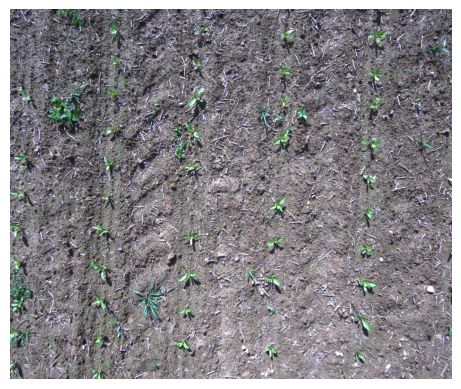

In [12]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the trained model
model = YOLO("runs/detect/train16/weights/best.pt")
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
results = model.predict(source=os.path.join(parent_dir,"imageSet/img/sugarbeet_bbch12_000001.png"), save=True, imgsz=640)

# Access predictions
for result in results:
    boxes = result.boxes.xyxy.numpy()  # all Bounding-Box-coordinates
    classes = result.boxes.cls.numpy()  # class-IDs
    sugarbeet_boxes = boxes[classes == 0] # all bounding boxes of sugarbeets
    print("Sugarbeet Boxes:", sugarbeet_boxes)

# plot image with predicted boundingboxes

image = mpimg.imread('runs/detect/predict/sugarbeet_bbch12_000001.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()
